[*********************100%***********************]  1 of 1 completed


-------------------------------Display Columns inside the dataset--------------------------
MultiIndex([(   'Adj Close', 'TATAMOTORS.NS'),
            (       'Close', 'TATAMOTORS.NS'),
            (        'High', 'TATAMOTORS.NS'),
            (         'Low', 'TATAMOTORS.NS'),
            (        'Open', 'TATAMOTORS.NS'),
            (      'Volume', 'TATAMOTORS.NS'),
            ('Price_Change',              ''),
            (    'Category',              '')],
           names=['Price', 'Ticker'])
-------------------------------Head of the dataset:----------------------------------------
Price          Adj Close         Close          High           Low  \
Ticker     TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                 
2015-01-02    503.038696    506.368683    511.909271    491.973083   
2015-01-05    514.833252    518.241333    520.417969    501.322815   
2015-01-06    492.816742    496.079071    508.89163

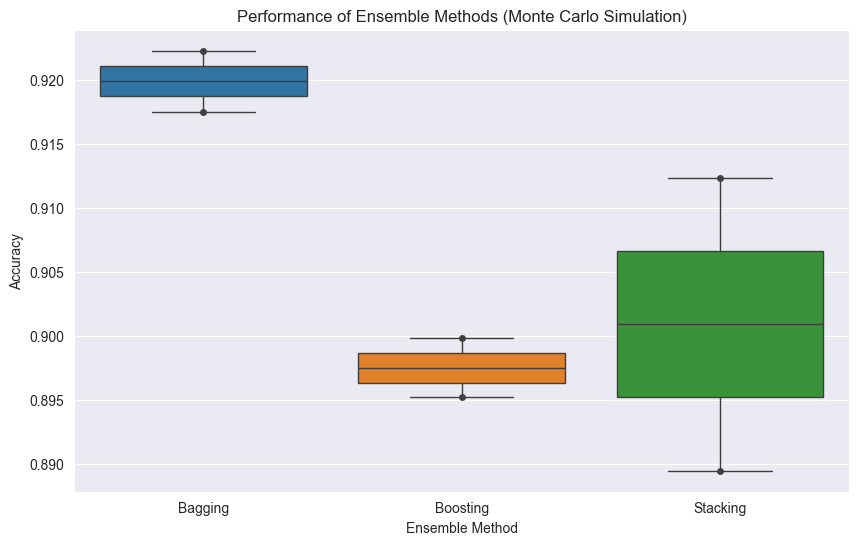

Bagging - Mean Accuracy: 0.9199, Std Dev: 0.0024
Boosting - Mean Accuracy: 0.8975, Std Dev: 0.0023
Stacking - Mean Accuracy: 0.9009, Std Dev: 0.0115
-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------

-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------


AttributeError: 'StockPricePredictor' object has no attribute 'features'

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
# Import statements
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import mplfinance as mpf
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

class Visualization:
    @staticmethod
    def plot_boxplot(results):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=pd.DataFrame(results))
        sns.swarmplot(data=pd.DataFrame(results), color=".25")
        plt.title("Performance of Ensemble Methods (Monte Carlo Simulation)")
        plt.ylabel("Accuracy")
        plt.xlabel("Ensemble Method")
        plt.show()

    @staticmethod
    def plot_regression_results(y_true, y_pred, title):

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.title(title)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.show()

class StockPricePredictor:
    def __init__(self, stock_symbol, start_date, end_date):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_balanced = None
        self.y_train_balanced = None

    def fetch_data(self):
        data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
        data['Price_Change'] = data['Close'].diff()
        data['Category'] = (data['Price_Change'] > 0).astype(int)
        self.data = data.dropna()

        # Data exploration
        print("-------------------------------Display Columns inside the dataset--------------------------")
        print(self.data.columns)
        print("-------------------------------Head of the dataset:----------------------------------------")
        print(self.data.head())
        print("-------------------------------Tail of the dataset:----------------------------------------")
        print(self.data.tail())
        print("-------------------------------Dataset Information:----------------------------------------")
        print(self.data.info())
        print("-------------------------------Descriptive Statistics:-------------------------------------")
        print(self.data.describe())
        print("-------------------------------Dataset Shape:----------------------------------------------")
        print(self.data.shape)
        print("-------------------------------Missing Values:---------------------------------------------")
        print(self.data.isnull().sum())
        print("-------------------------------------------------------------------------------------------")


    def feature_engineering(self):
        self.data['Volatility'] = self.data['High'] - self.data['Low']
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod()
        self.data['Moving_Avg_5'] = self.data['Close'].rolling(window=5).mean()
        self.data['Moving_Avg_10'] = self.data['Close'].rolling(window=10).mean()
        self.data['Exp_Moving_Avg'] = self.data['Close'].ewm(span=5, adjust=False).mean()
        self.data['Relative_Strength_Index'] = self.calculate_rsi(self.data['Close'], window=14)
        self.data['MACD'] = self.calculate_macd(self.data['Close'])
        self.data['Market_Trend'] = self.data['Close'] / self.data['Open'] - 1
        self.data['Volume_Change'] = self.data['Volume'].pct_change()
        self.data['Momentum'] = self.data['Close'] - self.data['Close'].shift(4)
        self.data['Avg_Volume_10'] = self.data['Volume'].rolling(window=10).mean()
        self.data['Price_to_Volume'] = self.data['Close'] / self.data['Volume']
        self.data = self.data.dropna()

    def calculate_rsi(self, prices, window):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices):
        ema_12 = prices.ewm(span=12, adjust=False).mean()
        ema_26 = prices.ewm(span=26, adjust=False).mean()
        return ema_12 - ema_26


    def prepare_data(self, test_size=0.2, random_state=None):
        features = [
            'Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Daily_Return', 'Cumulative_Return',
            'Moving_Avg_5', 'Moving_Avg_10', 'Exp_Moving_Avg', 'Relative_Strength_Index', 'MACD', 'Market_Trend', 'Volume_Change', 'Momentum',
            'Avg_Volume_10', 'Price_to_Volume'
        ]
        X = self.data[features]
        y = self.data['Category']

        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # We do not fix the random_state here to introduce variability
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

        smote = SMOTE(random_state=random_state)
        self.X_train_balanced, self.y_train_balanced = smote.fit_resample(self.X_train, self.y_train)

    def train_and_evaluate_models(self):
        # Remove fixed random_state for models or set them to None for variability
        models = {
            "Support Vector Machine": SVC(probability=True),
            "Logistic Regression": LogisticRegression(),
            "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
        }
        results = []

        for model_name, model in models.items():
            model.fit(self.X_train_balanced, self.y_train_balanced)
            predictions = model.predict(self.X_test)

            # Collect evaluation metrics
            accuracy = accuracy_score(self.y_test, predictions)
            class_report = classification_report(self.y_test, predictions)
            conf_matrix = confusion_matrix(self.y_test, predictions)

            # Print metrics
            print(f"-------------------------------- {model_name} ----------------------------------")
            print(f"Accuracy: {accuracy:.2f}")
            print("Classification Report:\n", class_report)
            print("Confusion Matrix:\n", conf_matrix)
            print("\n")

            # Append results for summary
            results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "Confusion Matrix": conf_matrix,
                "Classification Report": class_report
            })

        return results

    def train_and_evaluate_with_splits(self, test_sizes):
        overall_results = []

        for test_size in test_sizes:
            print(f"===================== Evaluating with Test Size: {test_size} =====================")
            # Introduce variability by not using a fixed random_state
            rand_state = np.random.randint(0, 10000)
            self.prepare_data(test_size=test_size, random_state=rand_state)
            split_results = self.train_and_evaluate_models()
            for result in split_results:
                result["Test Size"] = test_size
                overall_results.append(result)

        # Create a tabular summary
        results_summary = [
            {
                "Model": result["Model"],
                "Test Size": result["Test Size"],
                "Accuracy": result["Accuracy"]
            }
            for result in overall_results
        ]

        # Convert to a DataFrame
        results_df = pd.DataFrame(results_summary)

        # Sort results by Model for grouping
        results_df = results_df.sort_values(by="Model").reset_index(drop=True)

        print("\n===================== Tabular Evaluation Results =====================\n")
        print(results_df)

        return results_df

    def evaluate_ensemble_methods(self, monte_carlo_runs=2):
        # Remove fixed random_state from these models or vary them
        ensemble_methods = {
            "Bagging": BaggingClassifier(estimator=SVC(probability=True)),
            "Boosting": AdaBoostClassifier(estimator=LogisticRegression()),
            "Stacking": StackingClassifier(
                estimators=[
                    ('svc', SVC(probability=True)),
                    ('logreg', LogisticRegression()),
                    ('knn', KNeighborsClassifier(n_neighbors=5))
                ],
                final_estimator=GradientBoostingClassifier(),
                passthrough=False
            )
        }

        hyperparameter_grids = {
            "Bagging": {
                "n_estimators": [10, 20, 50, 100],
                "max_samples": [0.5, 0.7, 1.0],
                "max_features": [0.5, 0.7, 1.0]
            },
            "Boosting": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.5, 1.0]
            },
            "Stacking": {
                "final_estimator__learning_rate": [0.01, 0.1, 0.5],
                "final_estimator__n_estimators": [50, 100, 150]
            }
        }

        results = {method: [] for method in ensemble_methods.keys()}

        for run in range(monte_carlo_runs):
            test_size = np.random.uniform(0.2, 0.4)
            # Vary random_state each run
            rand_state = np.random.randint(0, 100000)
            self.prepare_data(test_size=test_size, random_state=rand_state)
            print("Monte Carlo Run: ", run)
            for method_name, model in ensemble_methods.items():
                param_grid = hyperparameter_grids.get(method_name, {})
                if param_grid:
                    # Remove fixed random_state or set it to None in RandomizedSearchCV
                    search = RandomizedSearchCV(
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=10,
                        scoring='accuracy',
                        random_state=None,  # No fixed seed for more variability
                        cv=3
                    )
                    search.fit(self.X_train_balanced, self.y_train_balanced)
                    best_model = search.best_estimator_
                    accuracy = accuracy_score(self.y_test, best_model.predict(self.X_test))
                    results[method_name].append(accuracy)
                else:
                    # If no param grid defined, just fit the model directly
                    model.fit(self.X_train_balanced, self.y_train_balanced)
                    accuracy = accuracy_score(self.y_test, model.predict(self.X_test))
                    results[method_name].append(accuracy)

        Visualization.plot_boxplot(results)

        return results

    def run_regression_with_pca(self):
        """
        Performs regression analysis using ensemble methods with and without PCA for feature reduction.
        Visualizes and interprets the results.
        """
        # Step 1: Select a continuous attribute as the target variable
        regression_target = 'Close'  # Example: predicting the closing price

        # Step 2: Prepare data with features and new target variable
        X = self.data[self.features].values  # Features
        y = self.data[regression_target].values  # Target

        # Step 3: Apply scaling and create train/test sets
        # You can choose between MinMaxScaler and StandardScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Split the data; no fixed random_state to introduce variability
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=None
        )

        # Step 4: Train and evaluate regression models, visualize and interpret results
        # Define regression ensemble methods
        regression_models = {
            "RandomForestRegressor": RandomForestRegressor(),
            "GradientBoostingRegressor": GradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(),
            "XGBRegressor": XGBRegressor()  # Use XGBRegressor for regression tasks
        }

        print("\nRegression Results without PCA:")
        for name, model in regression_models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

            # Visualization
            Visualization.plot_regression_results(
                y_test, preds, title=f"{name} - Without PCA"
            )

        # Step 5: Apply PCA to reduce dimensionality, retaining at least 90% of information
        pca = PCA(n_components=0.90)  # Retain 90% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        chosen_components = X_train_pca.shape[1]
        print(f"\nNumber of PCA components chosen to retain at least 90% variance: {chosen_components}")

        # Step 6: Apply regression on the extracted features, evaluate, and compare performance
        print("\nRegression Results with PCA:")
        for name, model in regression_models.items():
            model.fit(X_train_pca, y_train)
            preds_pca = model.predict(X_test_pca)
            mse_pca = mean_squared_error(y_test, preds_pca)
            r2_pca = r2_score(y_test, preds_pca)
            print(f"{name}(PCA) - MSE: {mse_pca:.4f}, R2: {r2_pca:.4f}")

            # Visualization
            Visualization.plot_regression_results(
                y_test, preds_pca, title=f"{name} - With PCA"
            )

        # Interpretation:
        # Compare the MSE and R2 scores before and after PCA.
        # A lower MSE and higher R2 indicate better performance.
        # If PCA does not significantly degrade performance, it justifies dimensionality reduction.

if __name__ == "__main__":
    predictor = StockPricePredictor('TATAMOTORS.NS', '2015-01-01', '2023-01-01')

    # Fetch and preprocess data
    predictor.fetch_data()

    # Perform Feature Engineering
    predictor.feature_engineering()

    # Prepare data for modeling with no fixed random state
    predictor.prepare_data(random_state=np.random.randint(0, 10000))

    # Train and evaluate the models
    predictor.train_and_evaluate_models()

    # Define a list of test sizes for evaluation
    test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

    # Train and evaluate with different test sizes
    evaluation_results = predictor.train_and_evaluate_with_splits(test_sizes)

    # Evaluate ensemble methods with Monte Carlo simulation
    ensemble_results = predictor.evaluate_ensemble_methods(monte_carlo_runs=2)

    # Display ensemble results summary
    for method, scores in ensemble_results.items():
        print(f"{method} - Mean Accuracy: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")

    print("-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------")
    # Step 8: Run regression analysis with PCA integration
    print("\n-----------------------------------------------------------------------------Regression Steps Commence----------------------------------------------------------------------------------")
    predictor.run_regression_with_pca()
